# Toronto COVID-19 Cases Project

Author: Adrienne Siu
Date: August 2020

# 1. Problem Definition

In this project, I will use machine learning to:
1. Predict which cases of COVID-19 in Toronto are fatal
2. Find the variables that correlate most with the outcome

The dataset is available on Toronto Open Data and the version from July 29, 2020 was used: https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

This dataset has been saved as 'COVID19 cases.csv'.

The three possible outcomes in the dataset are: 
1. Fatal
2. Resolved
3. Active (neither fatal nor resolved)

In [1]:
# DELETE
%qtconsole
import pdb
#import contextlib
#with contextlib.redirect_stdout(None):
#import pixiedust

#%%pixie_debugger
#pdb.set_trace()

# 2. Exploratory Data Analysis (EDA)

In this section, I will explore the data, including:
1. An overall view of the data and types of variables
2. Splitting the data into the training and validation sets
3. Generating plots of each feature.

## Overall view of the data and types of variables

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import math as mt
from datetime import datetime as dt

In [3]:
# Path of dataset file (.csv)
covid_file_path = 'COVID19 cases.csv'

# Read the file
covid_data = pd.read_csv(covid_file_path)

In [4]:
# Display the first few rows of the dataset
covid_data.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,2,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,3,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,4,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,5,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


Apart from _id and Assigned_ID, the columns seem to be helpful features to be used in training our models to predict the Outcome.

In [5]:
# Look for categorical variables
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15338 entries, 0 to 15337
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _id                     15338 non-null  int64 
 1   Assigned_ID             15338 non-null  int64 
 2   Outbreak Associated     15338 non-null  object
 3   Age Group               15311 non-null  object
 4   Neighbourhood Name      14729 non-null  object
 5   FSA                     14775 non-null  object
 6   Source of Infection     15338 non-null  object
 7   Classification          15338 non-null  object
 8   Episode Date            15338 non-null  object
 9   Reported Date           15338 non-null  object
 10  Client Gender           15338 non-null  object
 11  Outcome                 15338 non-null  object
 12  Currently Hospitalized  15338 non-null  object
 13  Currently in ICU        15338 non-null  object
 14  Currently Intubated     15338 non-null  object
 15  Ev

Apart from _id and Assigned_ID, the columns are all categorical variables. It would be useful to convert the Episode Date and Reported Date into datetime objects for analysis.

In [6]:
# Change Episode Date and Reported Date columns to datetimes
# Input: data: dataframe
# Output: dataframe with date columns as datetime objects
def change_to_datetime(data):
    data['Episode Date'] = pd.to_datetime(data['Episode Date'], format='%Y-%m-%d')
    data['Reported Date'] = pd.to_datetime(data['Reported Date'], format='%Y-%m-%d')
    return data

In [7]:
# Change Episode Date and Reported Date columns to datetimes
covid_data = change_to_datetime(covid_data)

In [8]:
# Check for duplicated entries
covid_data.duplicated().sum()

0

No duplicated entries.

## Define training and validation sets

In [9]:
from sklearn.model_selection import train_test_split

# Target: outcome
y = covid_data.Outcome

# Predictor: drop _id, Assigned_ID, and Outcome columns
X = covid_data.drop(['Outcome'], axis=1)

# Split into training and validation sets (80/20 split)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [10]:
# X_train.to_excel("X_train.xlsx")
# X_valid.to_excel("X_valid.xlsx")

## Describe variables in the training set

In [102]:
# Describe categorical variables
X_train.describe(include = ['O'])

,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Client Gender,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
count,11951,11929,11483,11520,11951,11951,11951,11951,11951,11951,11951,11951,11951
unique,2,9,140,96,8,2,5,1,1,1,2,2,2
top,Sporadic,50 to 59 Years,Glenfield-Jane Heights,M9V,N/A - Outbreak associated,CONFIRMED,FEMALE,No,No,No,No,No,No
freq,7424,1904,396,681,4527,11012,6341,11951,11951,11951,10509,11646,11739


Based on an expected count of 11951 in each column, it appears that Age Group, Neighbourhood Name, and FSA have missing values.

In [103]:
X_train[['Episode Date','Reported Date']].describe()

,Episode Date,Reported Date
count,11951,11951
unique,155,152
top,2020-04-15 00:00:00,2020-05-29 00:00:00
freq,244,357
first,2020-01-21 00:00:00,2020-01-23 00:00:00
last,2020-07-22 00:00:00,2020-07-25 00:00:00


The last episode date is 2020-07-22 and the last reported date is 2020-07-25.

Columns Neighbourhood Name, FSA, Episode Date, and Reported Date have > 90 unique entries, which will require feature engineering to address. The concern is that there will be too many dimensions.

In [12]:
y_train.describe()

count        12270
unique           3
top       RESOLVED
freq         11018
Name: Outcome, dtype: object

In [13]:
# Percentages for each outcome
y_train.value_counts()/y_train.count()*100

RESOLVED    89.796251
FATAL        7.603912
ACTIVE       2.599837
Name: Outcome, dtype: float64

89.8% of cases have been resolved and 7.6% of cases have been fatal. Hence, the vast majority of people recover from COVID-19.

Active cases form the smallest proportion (2.6%) of all cases. Furthermore, the information from active cases may not be helpful for the model, as we do not know if these cases will be resolved or fatal. Remember, the goal is to predict if a case is fatal or not. Hence, I will not analyze the active cases in the EDA and will remove them in the data cleaning step.

## Data cleaning

In this section, I will remove the active cases, as they are not useful for analysis.

In [14]:
# Remove Outcome = Active cases
# Get indices of active cases
active_idx_train = y_train[y_train=='ACTIVE'].index
active_idx_valid = y_valid[y_valid=='ACTIVE'].index

# Delete the row indices of active cases from y
y_train.drop(active_idx_train, inplace=True)
y_valid.drop(active_idx_valid, inplace=True)

# Delete the row indices of active cases from y
X_train.drop(active_idx_train, inplace=True)
X_valid.drop(active_idx_valid, inplace=True)

##

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Plot features for each outcome

To plot the features, I will merge the features (X_train) and the target (y_train).

In [15]:
train_df = pd.concat([X_train, y_train], axis=1)

In [16]:
train_df.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated,Outcome
14188,14189,14189,Sporadic,70 to 79 Years,Humber Summit,M9L,Close contact,CONFIRMED,2020-07-07,2020-07-08,FEMALE,No,No,No,No,No,No,RESOLVED
10181,10182,10182,Outbreak Associated,50 to 59 Years,Birchcliffe-Cliffside,M1N,N/A - Outbreak associated,CONFIRMED,2020-05-28,2020-05-31,FEMALE,No,No,No,Yes,Yes,No,RESOLVED
11273,11274,11274,Sporadic,70 to 79 Years,Clairlea-Birchmount,M1K,Close contact,CONFIRMED,2020-05-18,2020-05-20,FEMALE,No,No,No,No,No,No,RESOLVED
3535,3536,3536,Outbreak Associated,30 to 39 Years,Newtonbrook West,M2M,N/A - Outbreak associated,CONFIRMED,2020-04-19,2020-04-19,FEMALE,No,No,No,No,No,No,RESOLVED
10029,10030,10030,Sporadic,20 to 29 Years,York University Heights,M3J,Close contact,CONFIRMED,2020-05-18,2020-06-02,MALE,No,No,No,No,No,No,RESOLVED


In [17]:
# Function to obtain filtered entries in dataset
# Input: column_name is a string for the name of the column, e.g. 'Outbreak', 'Age Group'
#        filter_column is a string for the column to be filtered
#        filter_entry is a string for the entry to be filtered
# Ex. To filter only the fatal outcomes, filter_column = 'Outcome' and filter_entry = 'FATAL'
# Returns entries and value counts for the specific column after filtering
def get_filtered_entries_and_value_counts_from_column(column_name, filter_column, filter_entry):
    # Get the count of each unique entry (ordered by name)
    entry_vc = train_df[train_df[filter_column]==filter_entry][column_name].value_counts() #.sort_index()
    # Get the unique entries and put them in a list
    entry = entry_vc.index.tolist()    
    return entry, entry_vc

In [18]:
# Function to create a bar chart of a column variable with filters applied
# Stack by outcome: active, fatal, resolved
# Input: column_name is a string for the name of the column, e.g. 'Outbreak', 'Age Group'
#        filter_column is a string for the column to be filtered
#        filter_entry_list is a list of strings for entries to be filtered
def create_filtered_bar_chart(column_name, filter_column, filter_entry_list, fig_size):
    # Initialize lists of entries and value counts after filtering
    entry_list = []
    entry_vc_list = []
    
    # Figure size
    if fig_size == 'large':
        fig = plt.figure(figsize=(20,30))
        #plt.xticks(rotation=90)
    elif fig_size == 'medium':
        fig = plt.figure(figsize=(15,15))
    else:
        fig = plt.figure()

    # Loop through entries to be filtered
    for i in range(len(filter_entry_list)):
        # Entries and value counts for each filter
        entry, entry_vc = get_filtered_entries_and_value_counts_from_column(column_name, filter_column, filter_entry_list[i])
        # Append to list
        entry_list.append(entry)
        entry_vc_list.append(entry_vc)
        # Create a bar stacked for each filtered entry, e.g. 'Fatal', 'Active', 'Resolved'
        # Make vertical bar charts for Episode Date and Reported Date columns
        if column_name == 'Episode Date' or column_name == 'Reported Date':
            plt.bar(entry_list[i], entry_vc_list[i])
            plt.xticks(rotation=45)
        # Otherwise make horizontal bar charts
        else:
            plt.barh(entry_list[i], entry_vc_list[i])
            # Invert the y-axis so that the order of the entries is from top to bottom
            plt.gca().invert_yaxis()
        
    plt.title('Number of COVID-19 Cases By ' + column_name)
    plt.legend(filter_entry_list)
    plt.savefig('Plots/' + column_name + ' ' + str(i) + '.pdf')
    plt.show()

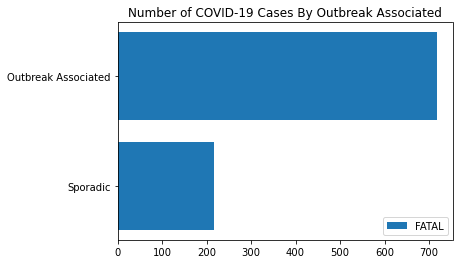

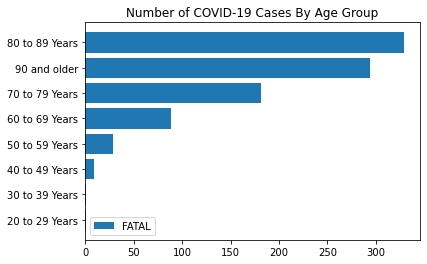

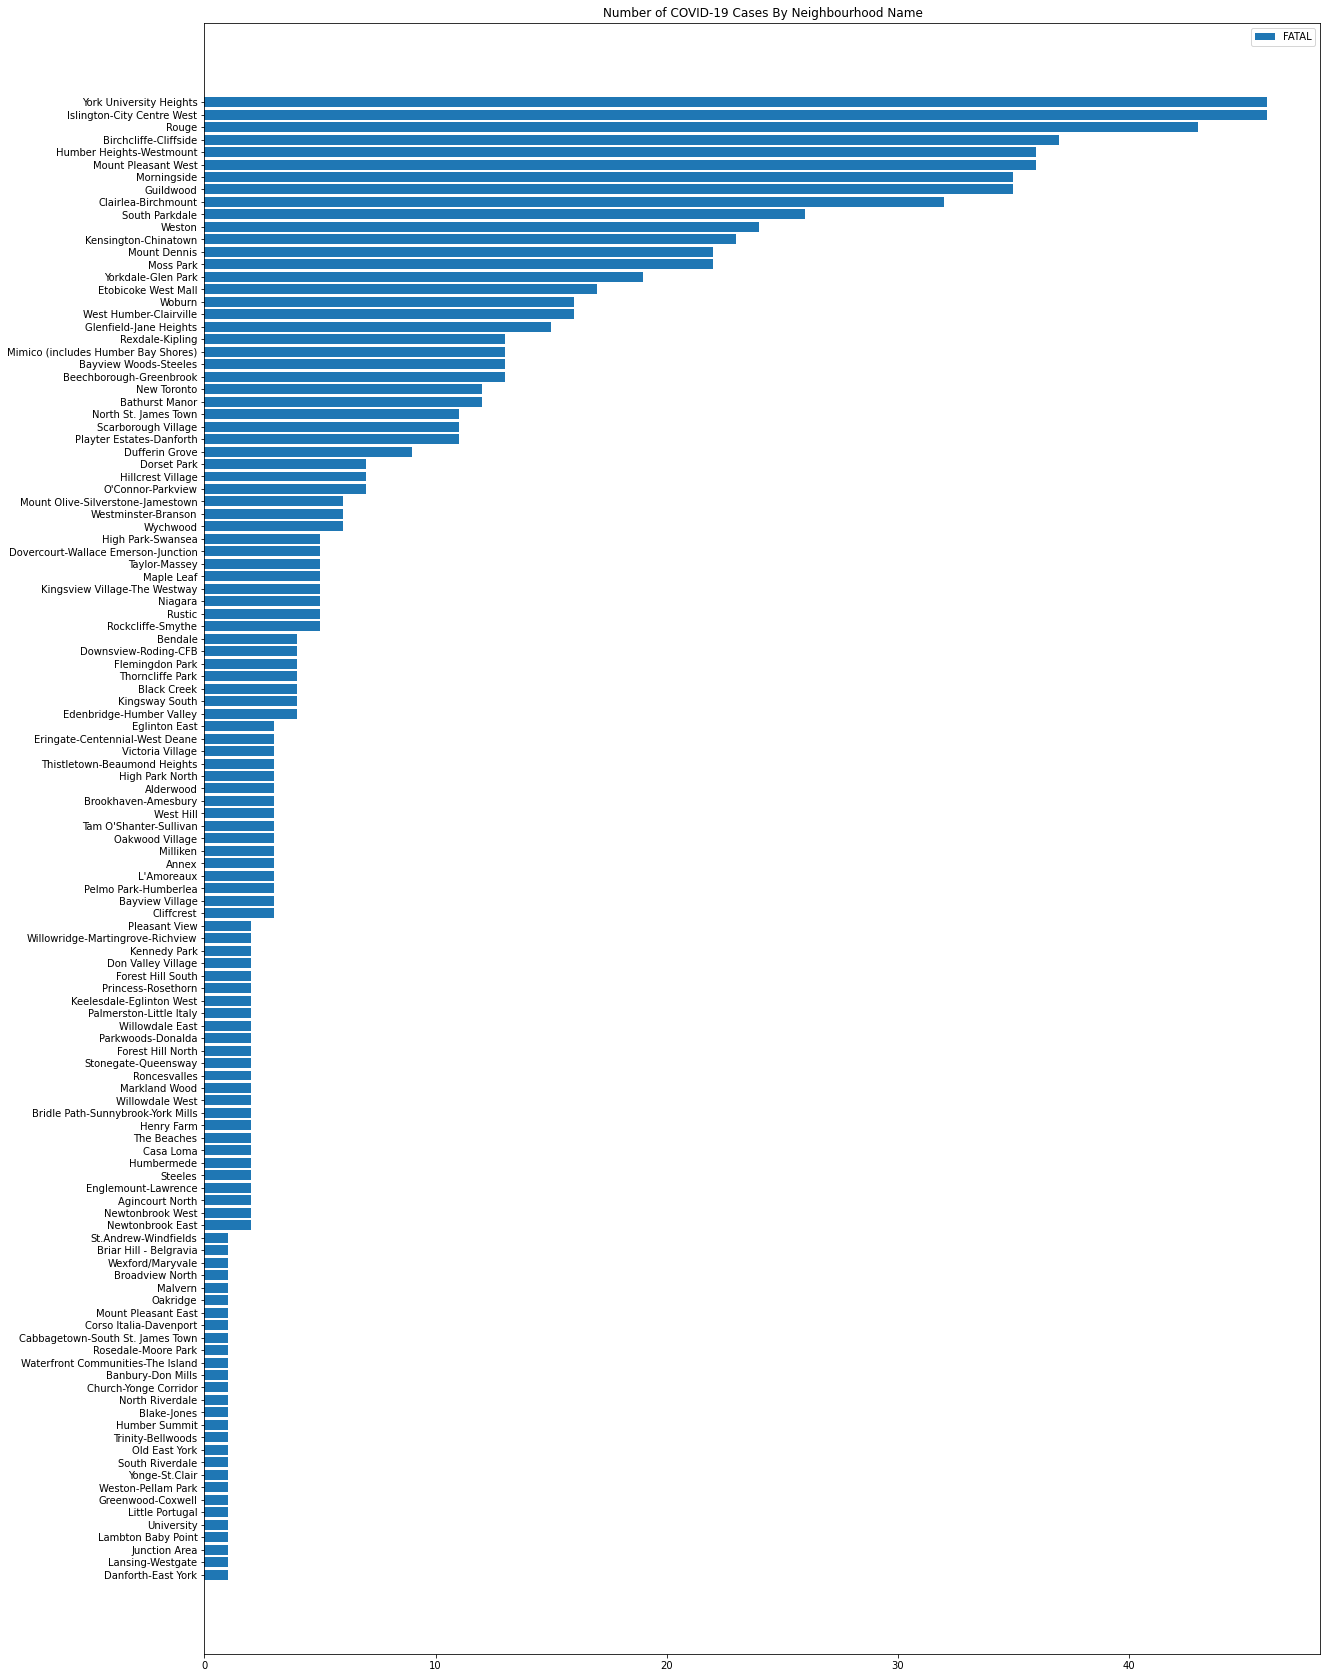

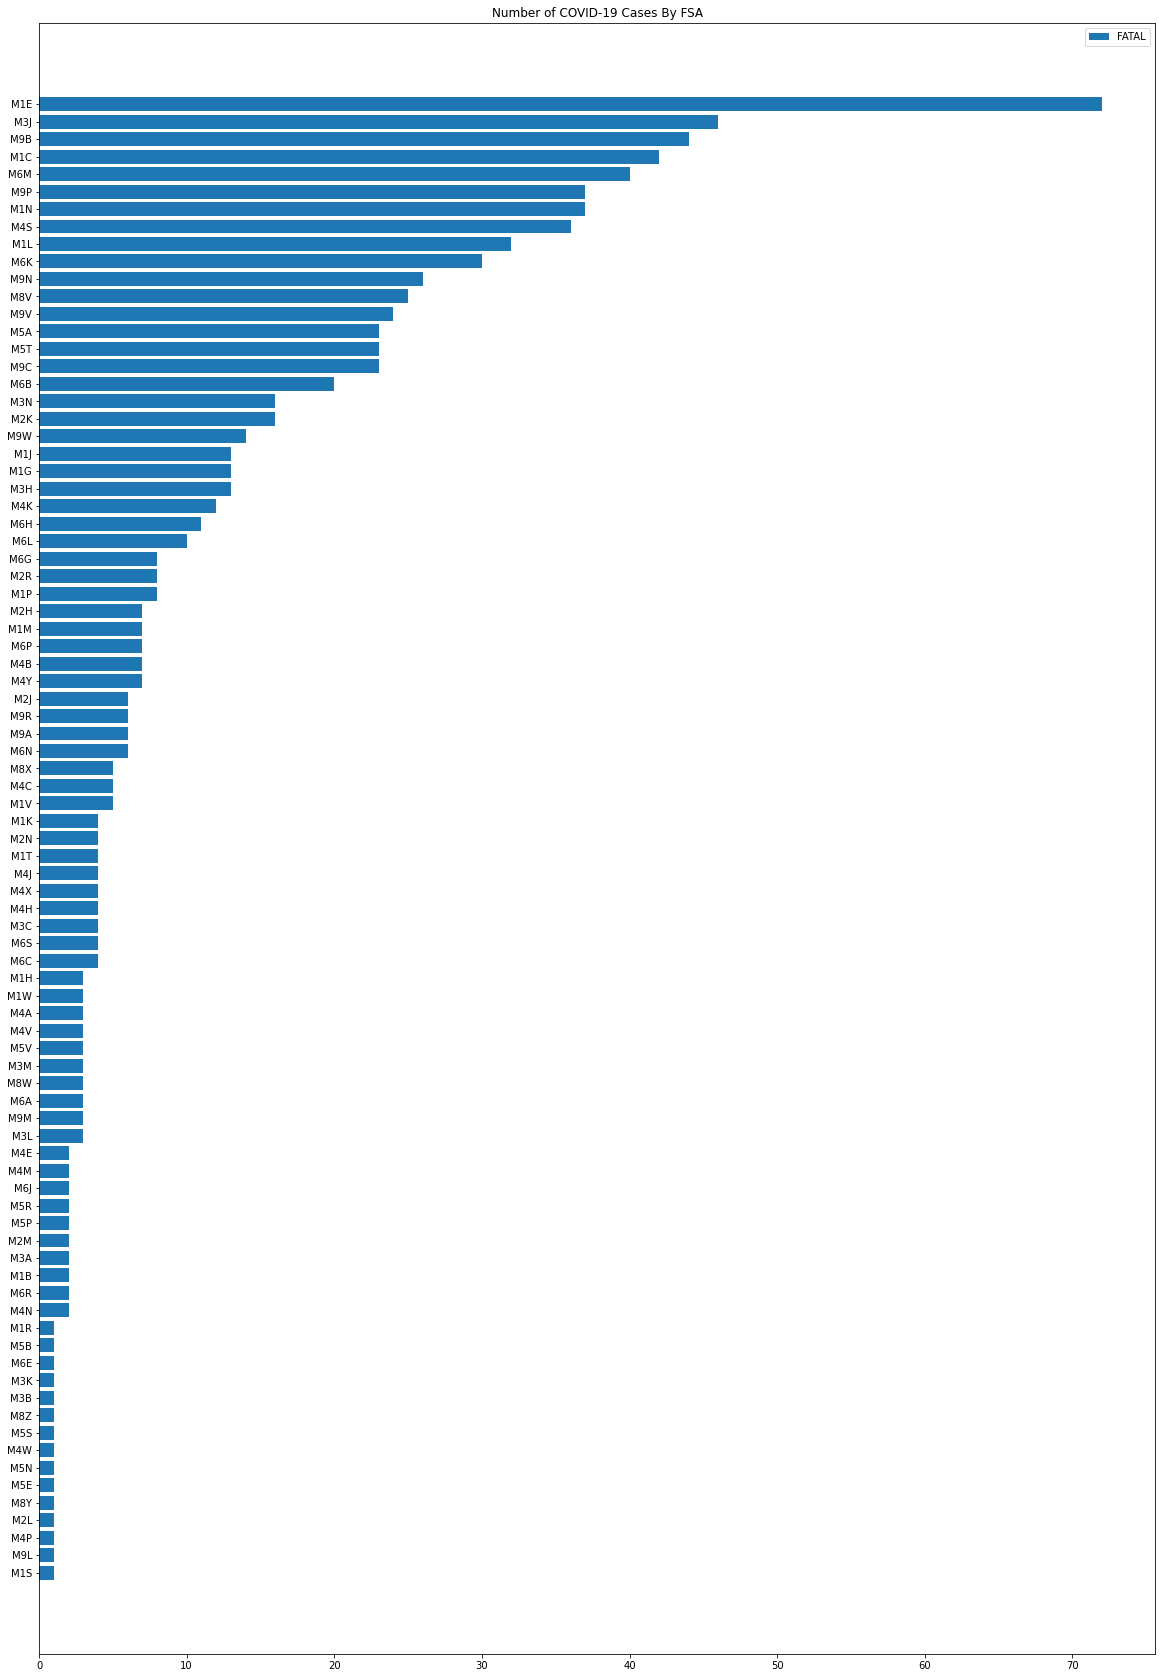

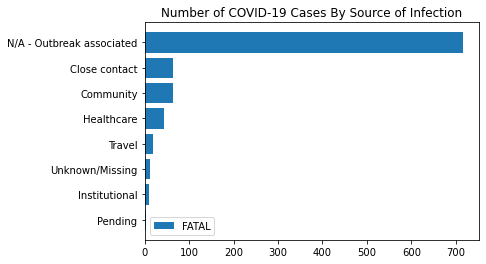

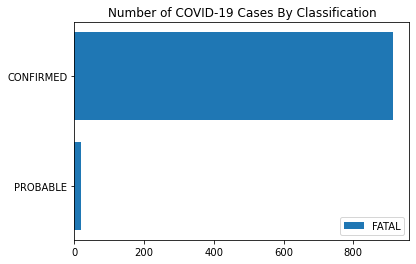

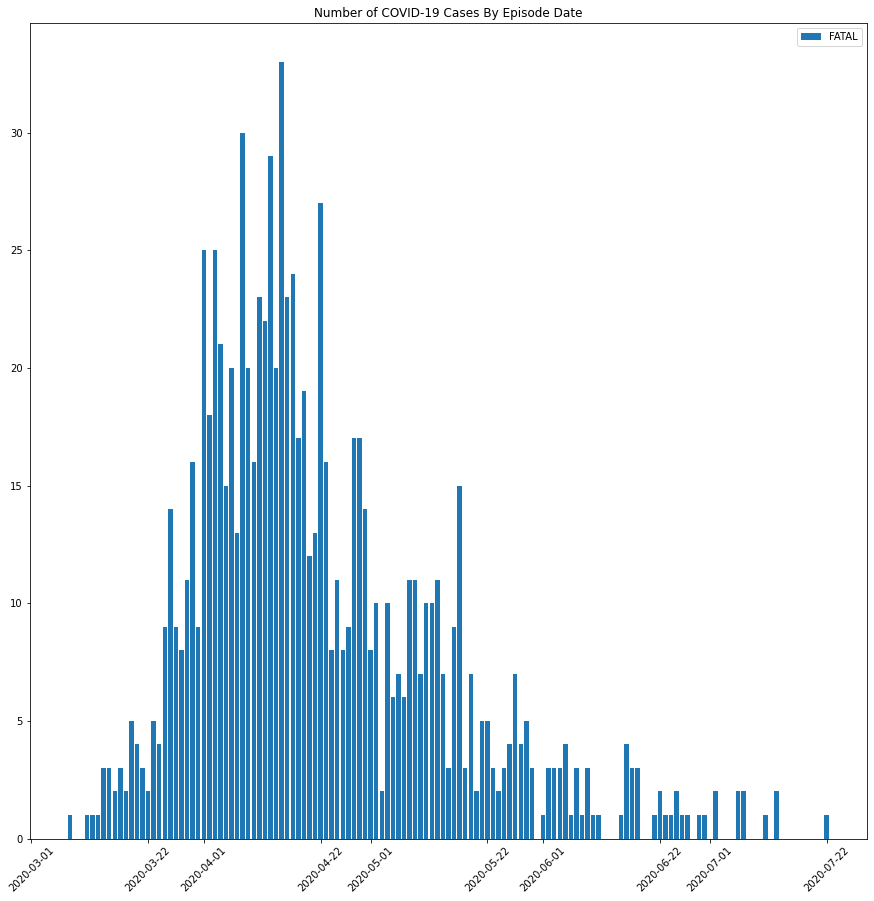

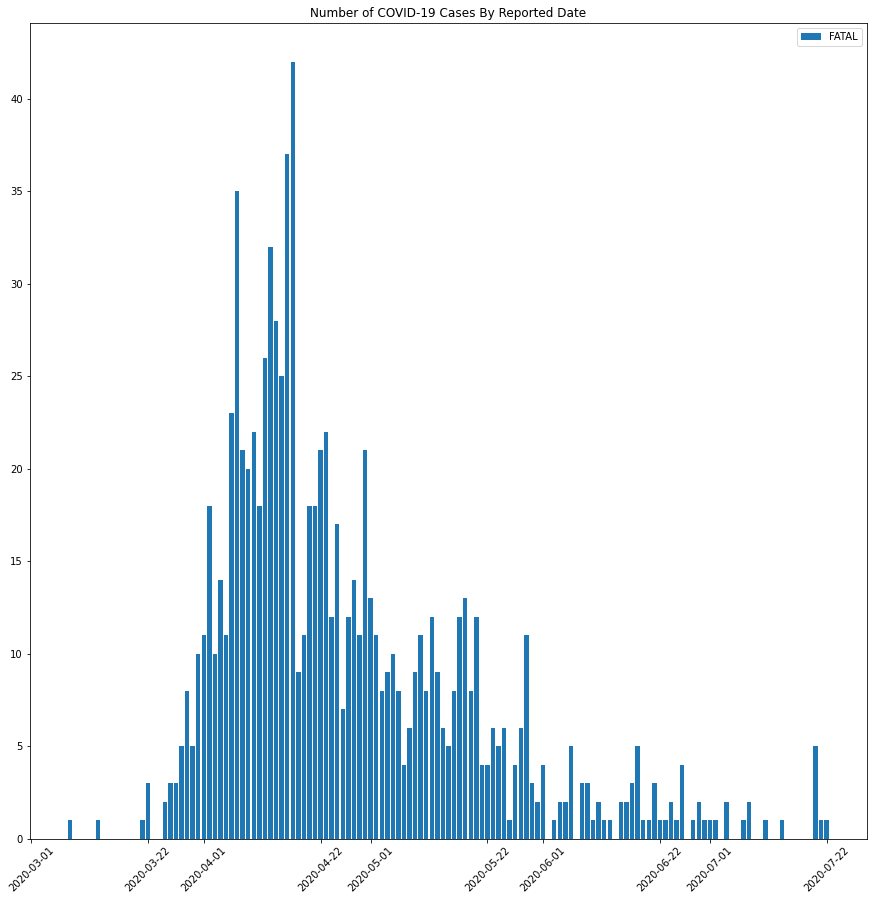

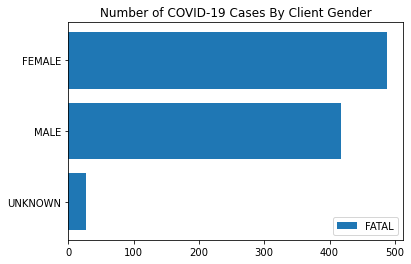

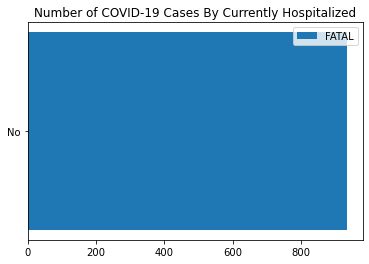

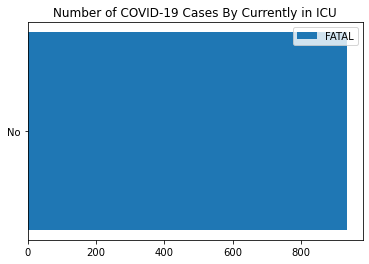

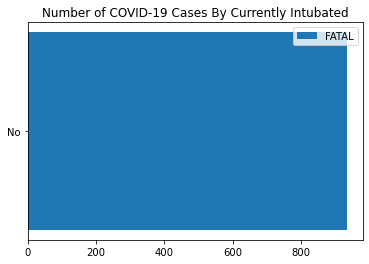

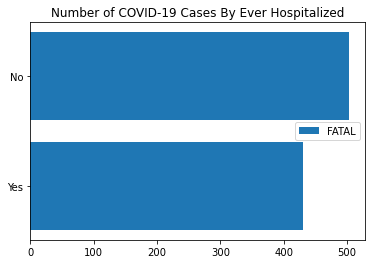

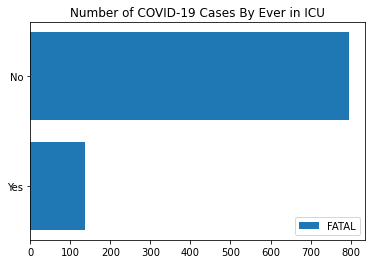

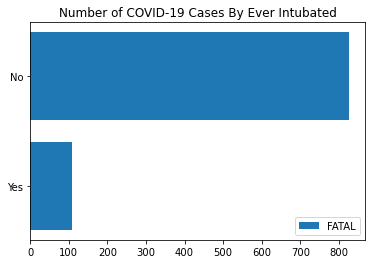

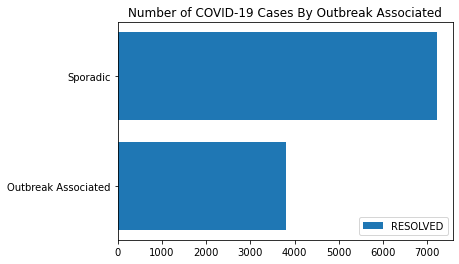

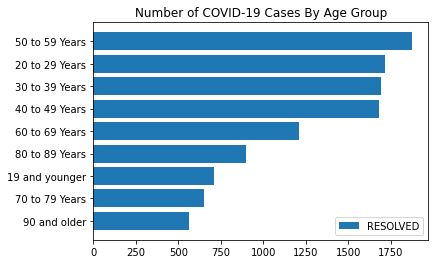

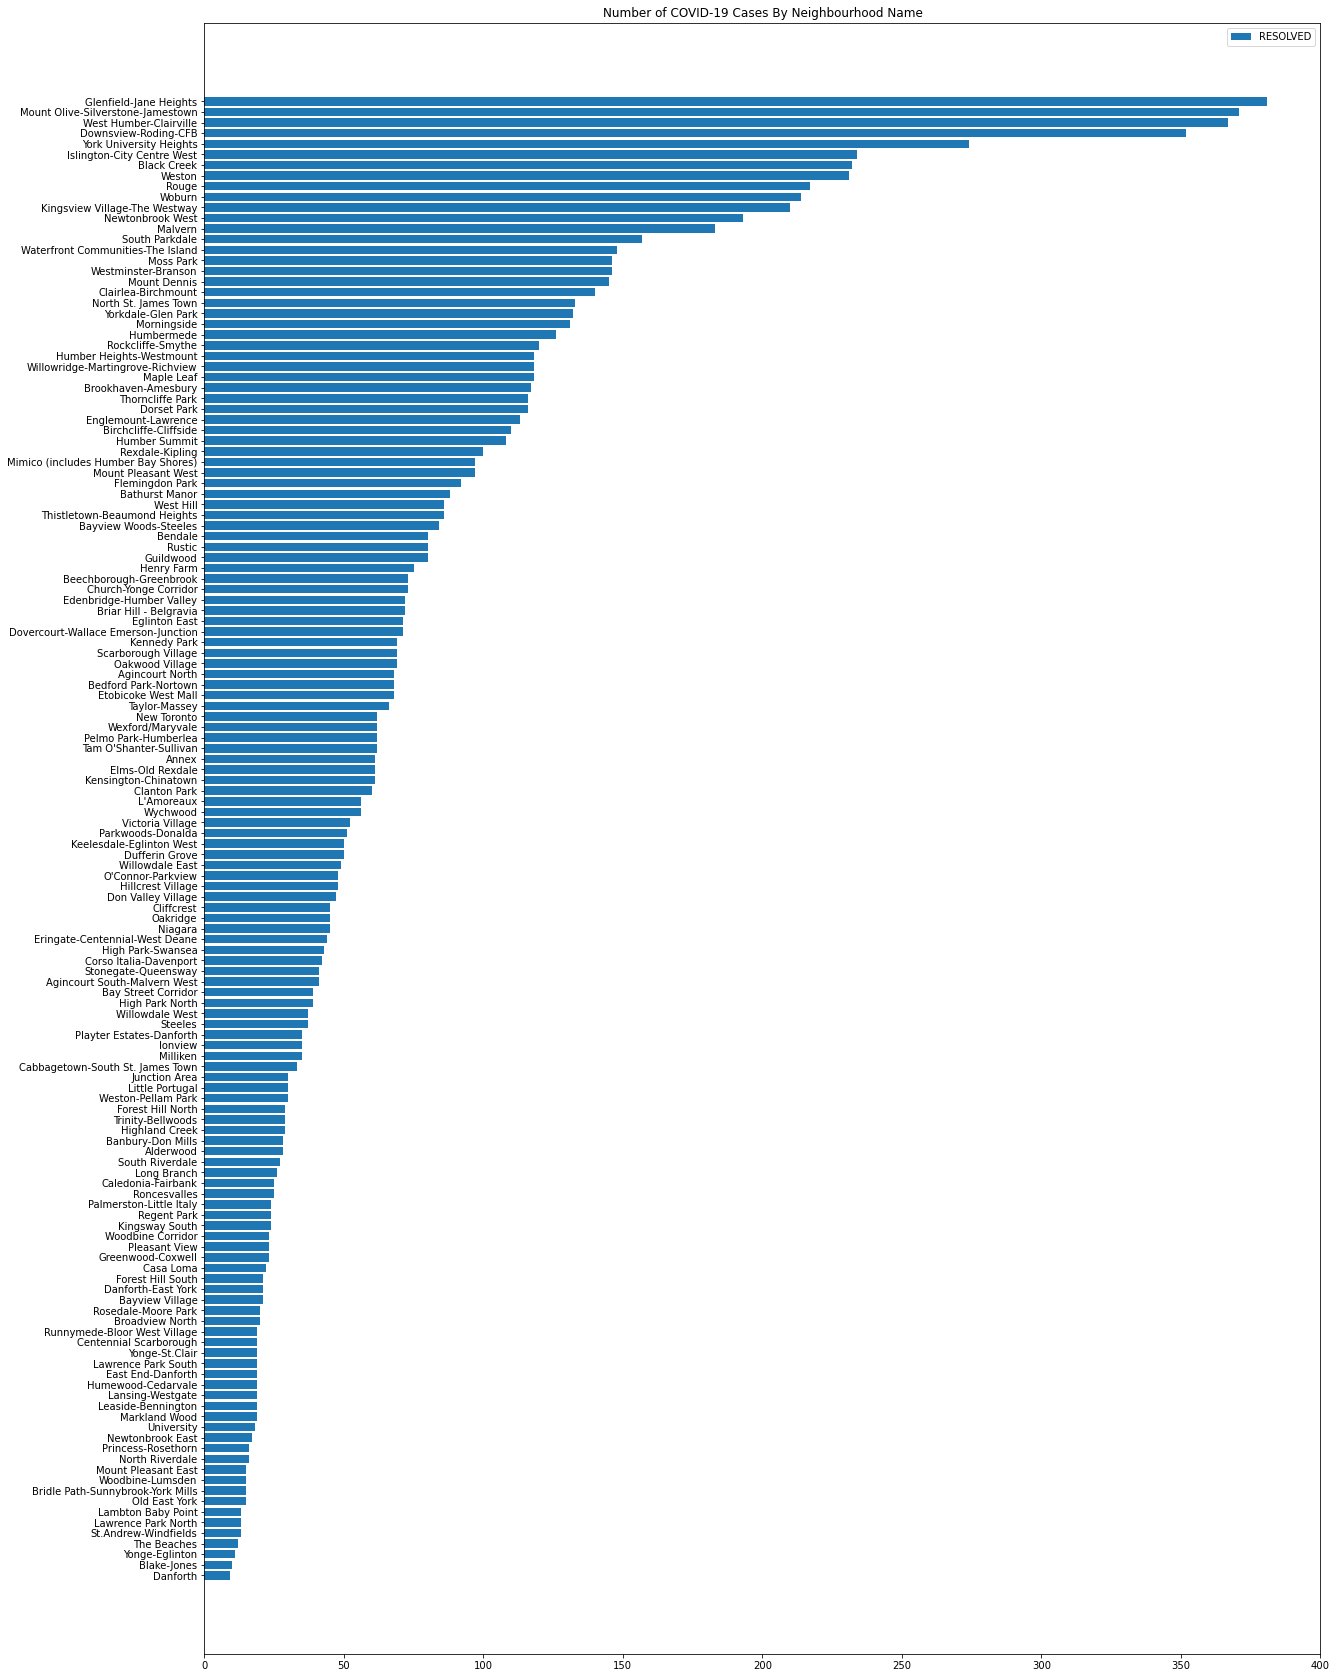

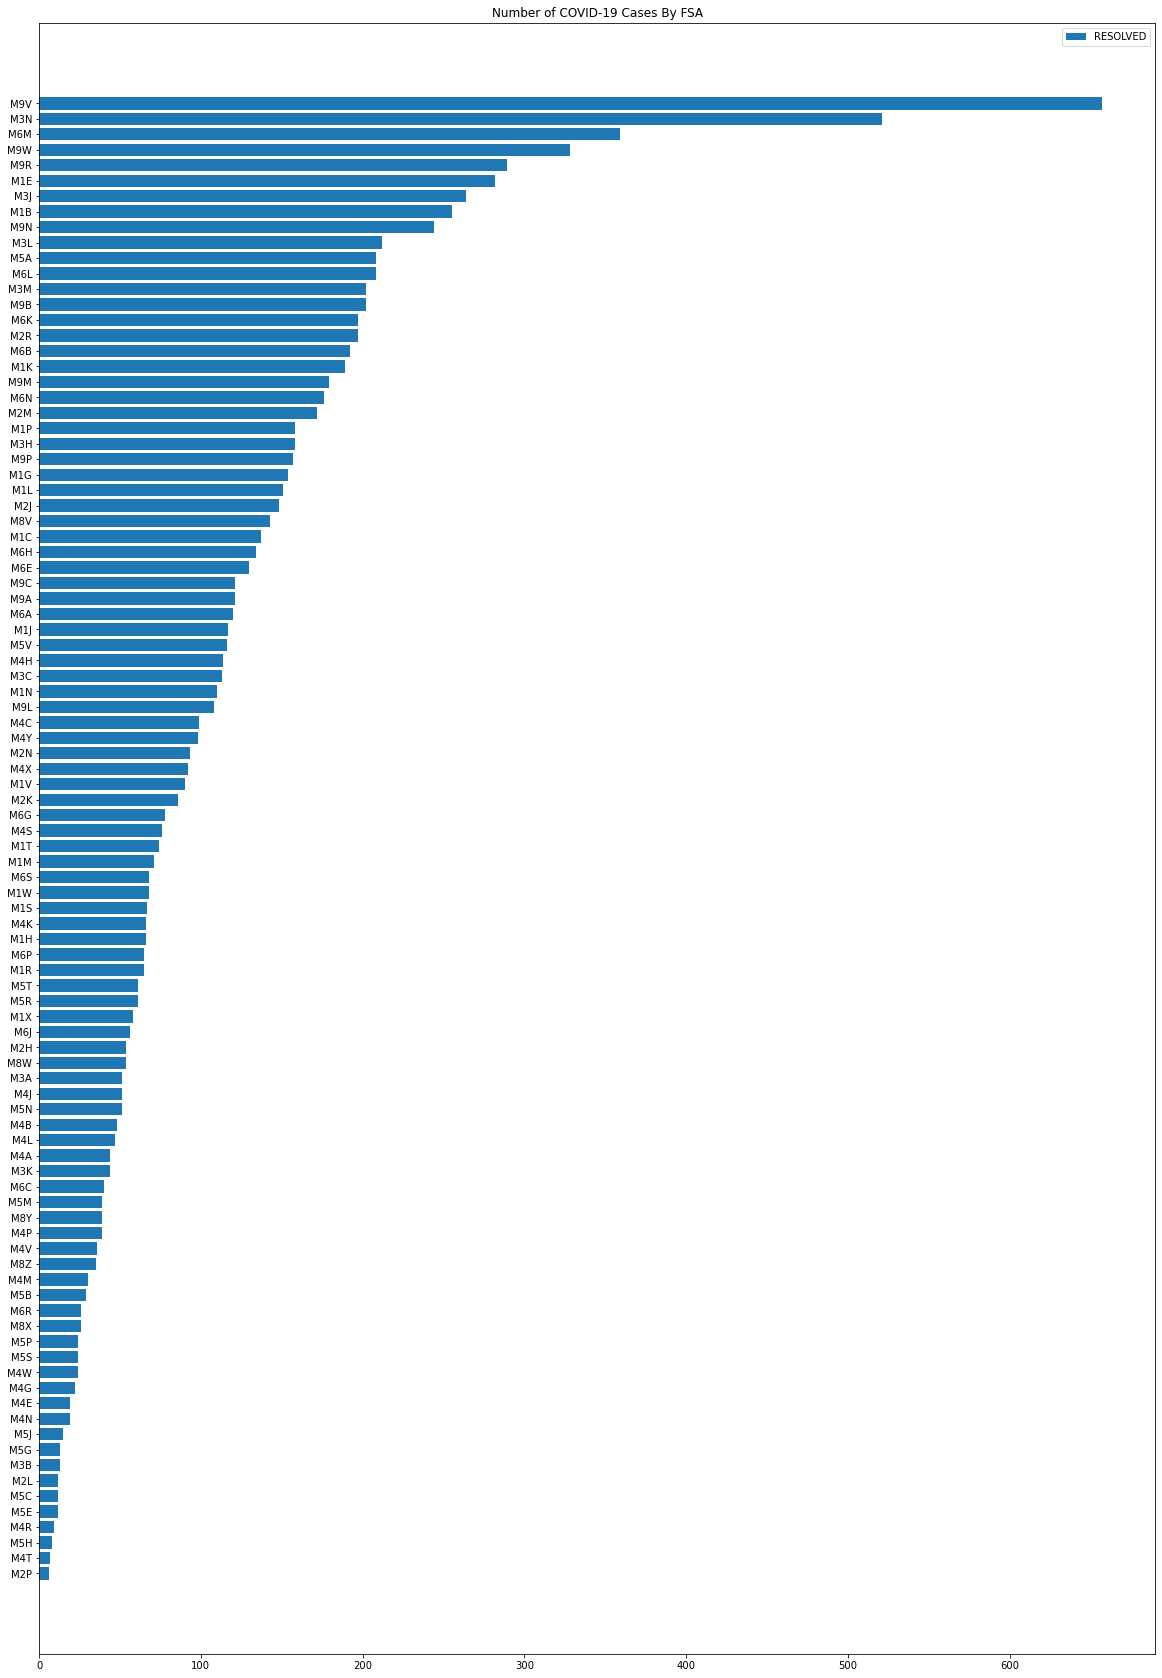

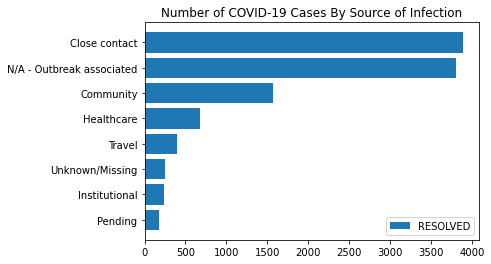

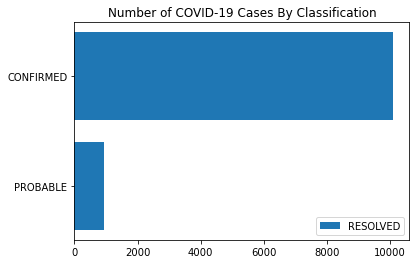

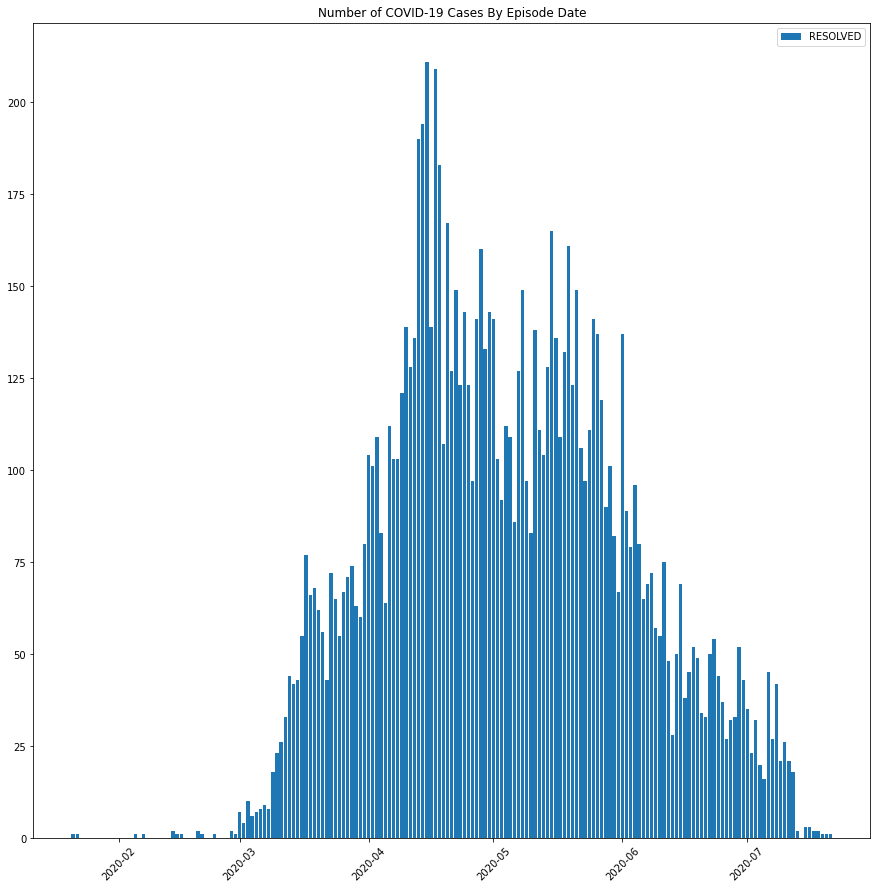

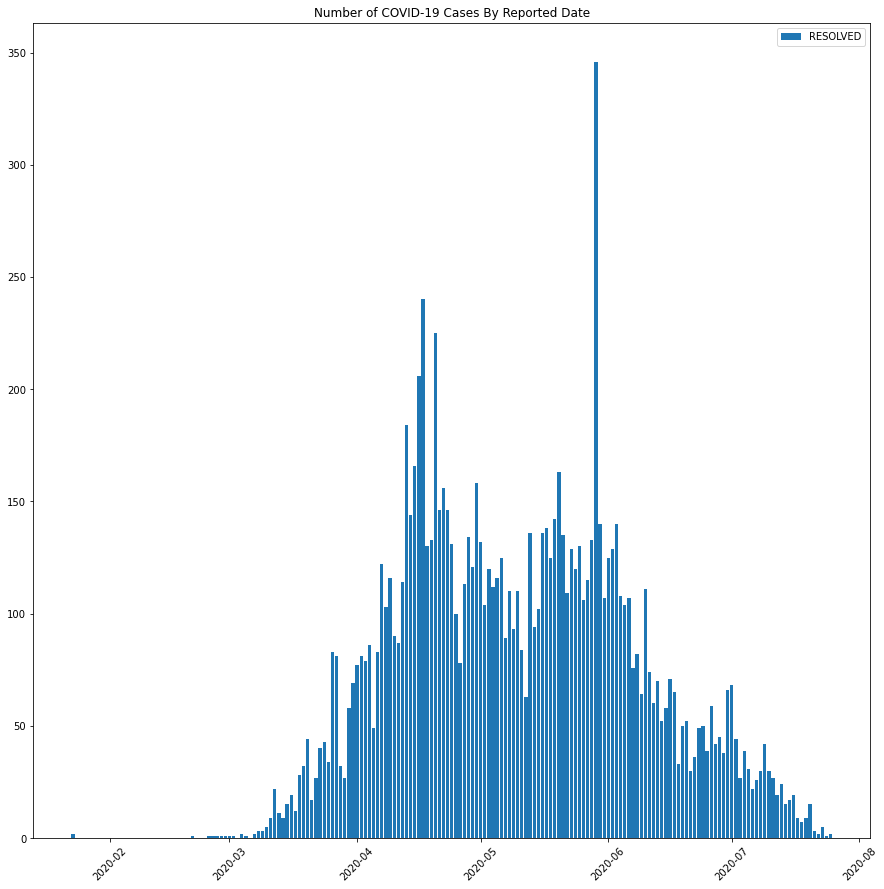

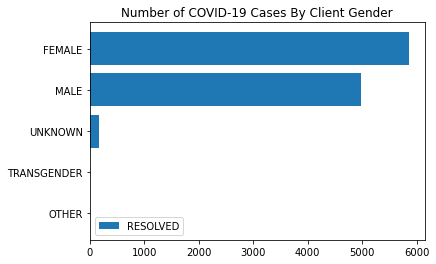

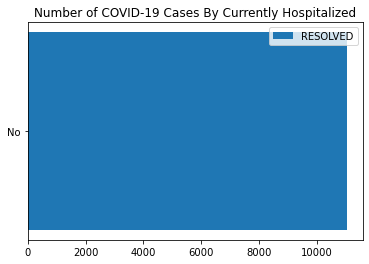

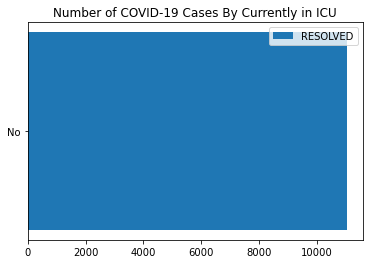

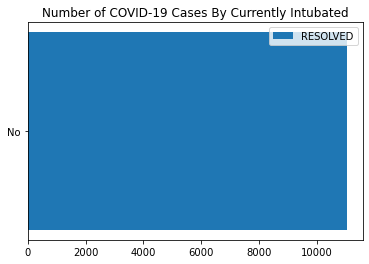

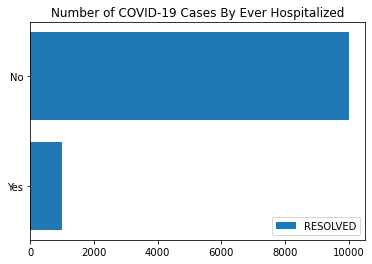

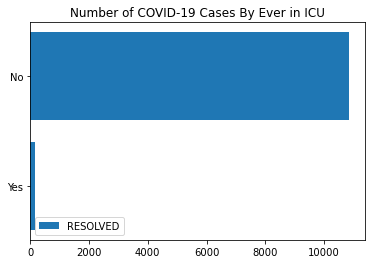

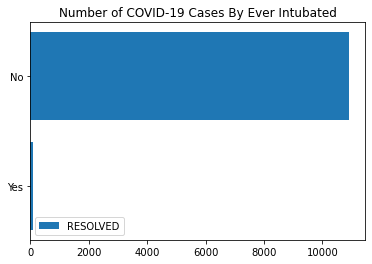

In [19]:
# Put the column names of the dataset into a list
columns = train_df.columns

# Remove the first two column names (the IDs) and Outcome column because I don't need to graph them
columns_no_IDs = columns[2:-1]

# Column to be filtered
filter_column = 'Outcome'
# Entries to be filtered:
# First make stacked bar charts of all three outcomes, then bar charts of only fatal outcomes
filter_entry_list = [['FATAL'], ['RESOLVED']]

for j in range(len(filter_entry_list)):
    # Create bar charts for relevant columns
    for column in columns_no_IDs:
        #create_bar_chart(column)
        # Figure size
        if column == 'Neighbourhood Name' or column == 'FSA': # or column == 'Episode Date' or column == 'Reported Date':
            fig_size = 'large'
        elif column == 'Episode Date' or column == 'Reported Date':
            fig_size = 'medium'
        else:
            fig_size = 'normal'

        create_filtered_bar_chart(column, filter_column, filter_entry_list[j], fig_size)

Fatal cases:
1. Most are outbreak-associated.
2. Most occur in the elderly (60+ years of age), generally with fatality increasing with age group.
3. The top neighbourhoods with fatalities are York University Heights, Islington-City Centre West, and Rouge. Although many neighbourhoods were affected, the top neighbourhoods had 40 - 50 cases, whereas the bottom neighbourhoods had < 5 cases.
4. The top FSA with fatalities is M1E, with > 70 cases, compared to the next FSA with ~ 47 cases.
5. The vast majority of cases are confirmed (vs. probable).
6. April and May had the most fatalities by episode date and reported date.
7. There have been ~ 15% more fatal cases within females than males. Hence, the disease doesn't have a clear preference for causing fatality in one gender over another.
8. None of the fatal cases are currently hospitalized, or currently in ICU, or currently intubated.
9. 20% more cases have never been hospitalized (vs. having been hospitalized). There are 6 times more fatal cases who have never been in ICU (vs. having been in ICU). There are 8.5 times more fatal cases who have never been intubated (vs. those who have been intubated). Hence, the disease causes fatalities in both previously healthy and unhealthy people.

Resolved cases:
1. Most are sporadic cases.
2. Most occur in those less than 60 years of age. The 50 - 59 age group has the most resolved cases.
3. The top neighbourhoods with resolved cases are Glenfield-Jane Heights, Mount Olive-Silverstone-Jamestown, and West Humber-Clairville. From the top neighbourhoods with fatalities: York University Heights is 5th in terms of resolved cases, Islington-City Centre West is 6th, and Rouge is 9th. Hence, the top neighbourhoods with fatalities also tend to have many resolved cases.
4. The top FSAs with resolved cases are M9V with ~ 660 cases, and M3N with ~ 520 cases.
5. The resolved cases are roughly split between contraction by close contact and outbreak.
6. There are 10 times more confirmed cases than probable cases.
7. April and May had the most resolved cases by episode date and reported date.
8. There are ~ 15% more resolved cases within females than males, which is similar to the fatality rate by gender. Hence, ~ 15% more females contract the disease, but the fatal cases are commensurate with this proportion.
9. None of the resolved cases are currently hospitalized, or currently in ICU, or currently intubated.
10. 10 times more cases have never been hospitalized (vs. having been hospitalized). The vast majority have never been intubated or in the ICU.

## Correlate features

                                    len
Outbreak Associated Outcome            
Sporadic            RESOLVED  97.090517
Outbreak Associated RESOLVED  84.161696
                    FATAL     15.838304
Sporadic            FATAL      2.909483
                                len
Age Group      Outcome             
19 and younger RESOLVED  100.000000
20 to 29 Years RESOLVED   99.941759
30 to 39 Years RESOLVED   99.940863
40 to 49 Years RESOLVED   99.466825
50 to 59 Years RESOLVED   98.476891
60 to 69 Years RESOLVED   93.153846
70 to 79 Years RESOLVED   78.271309
80 to 89 Years RESOLVED   73.164763
90 and older   RESOLVED   65.774156
               FATAL      34.225844
80 to 89 Years FATAL      26.835237
70 to 79 Years FATAL      21.728691
60 to 69 Years FATAL       6.846154
50 to 59 Years FATAL       1.523109
40 to 49 Years FATAL       0.533175
30 to 39 Years FATAL       0.059137
20 to 29 Years FATAL       0.058241
                                                     len
Neighbourhood Name 

                                          len
Source of Infection       Outcome            
Close contact             RESOLVED  98.359414
Pending                   RESOLVED  97.752809
Institutional             RESOLVED  96.326531
Community                 RESOLVED  96.151497
Unknown/Missing           RESOLVED  95.488722
Travel                    RESOLVED  95.388350
Healthcare                RESOLVED  93.922652
N/A - Outbreak associated RESOLVED  84.161696
                          FATAL     15.838304
Healthcare                FATAL      6.077348
Travel                    FATAL      4.611650
Unknown/Missing           FATAL      4.511278
Community                 FATAL      3.848503
Institutional             FATAL      3.673469
Pending                   FATAL      2.247191
Close contact             FATAL      1.640586
                               len
Classification Outcome            
PROBABLE       RESOLVED  98.083067
CONFIRMED      RESOLVED  91.690883
               FATAL      8.3091

                               len
Client Gender Outcome             
OTHER         RESOLVED  100.000000
TRANSGENDER   RESOLVED  100.000000
FEMALE        RESOLVED   92.304053
MALE          RESOLVED   92.282066
UNKNOWN       RESOLVED   86.000000
              FATAL      14.000000
MALE          FATAL       7.717934
FEMALE        FATAL       7.695947
                                       len
Currently Hospitalized Outcome            
No                     RESOLVED  92.193122
                       FATAL      7.806878
                                 len
Currently in ICU Outcome            
No               RESOLVED  92.193122
                 FATAL      7.806878
                                    len
Currently Intubated Outcome            
No                  RESOLVED  92.193122
                    FATAL      7.806878
                                  len
Ever Hospitalized Outcome            
No                RESOLVED  95.213626
Yes               RESOLVED  70.180305
                  

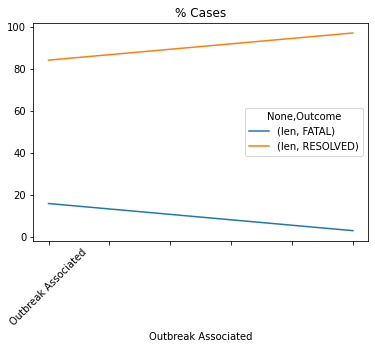

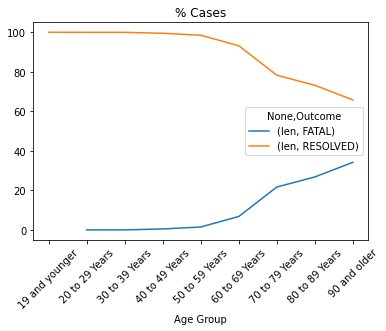

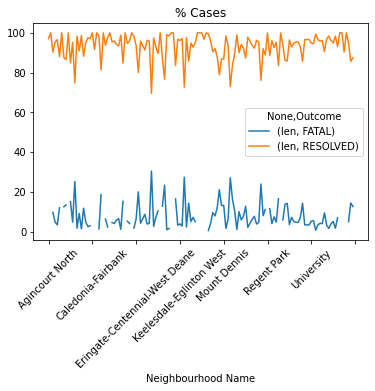

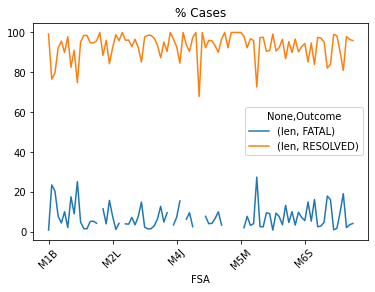

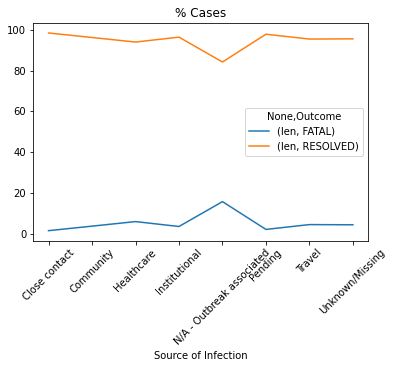

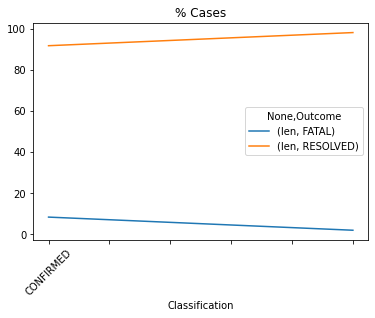

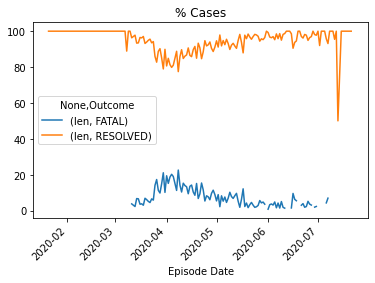

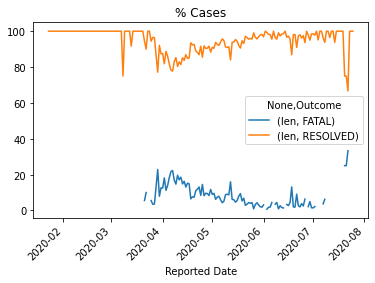

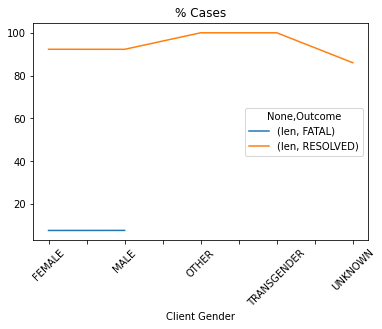

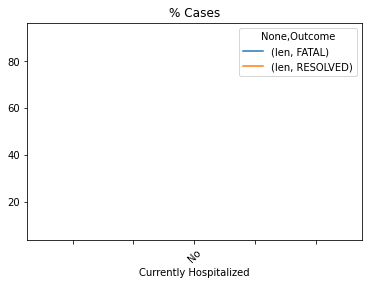

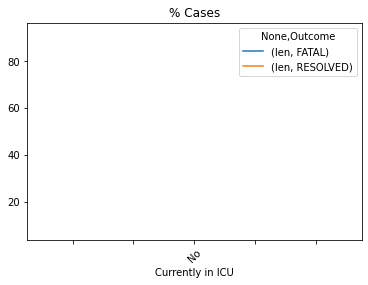

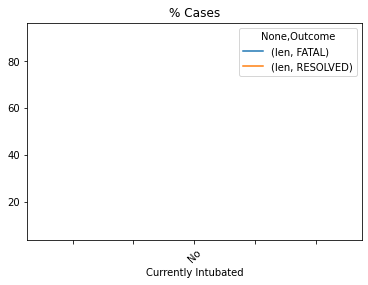

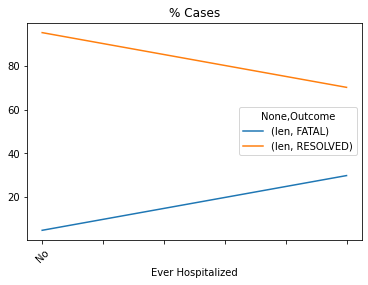

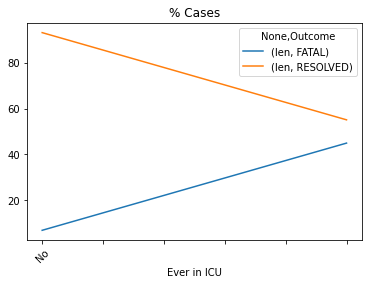

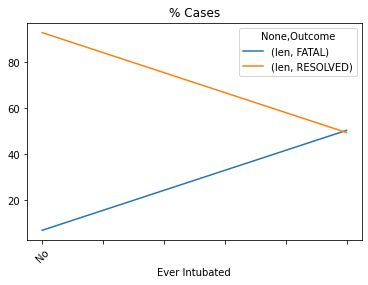

In [100]:
# Columns for correlations
column_corr = train_df.columns[2:-1]

# Set maximum rows to be displayed
pd.set_option('display.max_rows', 300)

#fig = plt.figure(figsize=(20,30))

# Loop through all columns
for col in column_corr:
    col_grp = train_df.groupby([col, 'Outcome'])['Outcome'].agg([len])
    col_perc = col_grp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).sort_values(by='len', ascending=False)
    print(col_perc)
    #fig, ax = plt.subplots()
    col_perc.unstack().plot()
    #ax.set_xlabel('Percent of Cases')
    plt.title('% Cases')
    plt.xticks(rotation=45)

Fatal cases are associated with:
1. Outbreak-associated cases (15.8% fatal)
2. Older patients (60+) (fatality increases with age group)
3. Certain neighbourhoods (Guildwood 30.4%, Kensington-Chinatown 27.4%, Mount Pleasant West 27.1%)
4. Certain FSAs (M4S 32.1%, M5T 27.4%, M1N 25.2%)
5. Confirmed cases (8.3%)
6. Certain episode dates (2020-07-22 100%, 2020-07-13 50%.0, 2020-04-08 22.6%) **[Note that the data is up until 2020-07-29, which means that most cases near that date were active. 2020-07-22 and 2020-07-13 appear to be outliers.]
7. Certain reported dates (2020-07-22 33.3%, 2020-03-08 25.0%, 2020-07-21 25.0%)
8. Unknown gender (14.0%)
9. Ever hospitalized (29.8%), ever in ICU (44.9%), ever intubated (50.5%)

**Note that no cases are currently hospitalized, currently in ICU, or currently intubated. So I will consider removing these columns from analysis to simplify modelling.

**Further considerations:
It would be worth assessing the correlations between the following features, due to the fact that there are many unique entries that could complicate modelling:
-- Neighbourhood Name and FSA (both stem from the patient's postal code)
-- Episode Date and Reported Date (the reported date is after the episode date)


## 3. Missing values

I will check for missing values in the training set.

In [ ]:
# Function to create a table of missing values in columns
# Function written by Nikos Tavoularis on Stack Overflow: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/39734251#39734251
# Function comments by AS
def missing_values_table(df):
        # Count the number of missing values in each column
        mis_val = df.isnull().sum()
        # Calculate the percentage of missing values in each column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # Put the number of missing values and % missing values in a table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns of the table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Take out columns with no missing values
        # Reorder columns with missing values in descending order
        # Round % missing values to 1 decimal place
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print summary
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        # Return table of missing values
        return mis_val_table_ren_columns

In [ ]:
# Create table of missing values
missing_values_table(X_train)

As observed, there are only 3/17 columns with missing values. For each column, the % missing values is < 4%. Hence, the dataset is fairly complete.

There are missing values for the age group, neighbourhood name, and FSA. I will fill in the missing values as follows:

-- If both the neighbourhood name and FSA are blank, find the modal FSA and neighbourhood name (as a pair).
Note I am not using SimpleImputer because I would like to consider the relationship between the neighbourhood name and FSA. If the modal neighbourhood name and modal FSA are treated separately as in SimpleImputer, the resulting pair
of neighbourhood name and FSA could be impossible in real life.

-- If the neighbourhood name is blank but the FSA is known, find the modal neighbourhood name for the given FSA.

-- Note that there are no cases of the FSA being blank but the neighbourhood name is known.

-- The age group will be filled with modal imputation, i.e. the modal age group. Note that the median and the modal age group in the training set are the same, so median imputation would also yield the same result.

In [ ]:
# Functions for neighbourhood name and FSA imputation
# If both the neighbourhood and FSA are blank, find the modal FSA and neighbourhood name (as a pair)
# Input: dataset for imputation
# Output: modal FSA and neighbourhood name, sorted dataset
def find_mode_fsa_nn(data):
    # Group data by FSA and neighbourhood and count number of occurrences
    fsa_nn_group_data = data.groupby(['FSA', 'Neighbourhood Name'])['Outbreak Associated'].agg([len]).reset_index()
    # Sort from highest to lowest count (i.e. the mode is the first value)
    fsa_nn_group_data_sorted = fsa_nn_group_data.sort_values(by='len', ascending=False)
    # Find modal neighbourhood name and FSA
    mode_fsa = fsa_nn_group_data_sorted.iloc[0]['FSA']
    mode_nn = fsa_nn_group_data_sorted.iloc[0]['Neighbourhood Name']
    return mode_fsa, mode_nn, fsa_nn_group_data_sorted

# Impute missing values for the neighbourhood name and FSA
# Note there are no cases when the neighbourhood name is known but the FSA is blank
# Input: dataset, sorted dataset
def impute_missing_fsa_nn(data, mode_fsa, mode_nn, fsa_nn_group_data_sorted):
    # If an entry is blank, it is a 'NaN' and hence a float
    # If an entry is not blank, it is a string
    for i in data.index:
         # If both the neighbourhood name and FSA are blank
        if type(data['Neighbourhood Name'][i]) == float and type(data['FSA'][i]) == float:
            # Use the modal FSA and neighbourhood name
            data['FSA'][i] = mode_fsa
            data['Neighbourhood Name'][i] = mode_nn
            #print("Instance 1", i, data['FSA'][i], data['Neighbourhood Name'][i])

         # If the neighbourhood name is blank but the FSA is known
        if type(data['Neighbourhood Name'][i]) == float and type(data['FSA'][i]) != float:
            # Find the modal neighbourhood name for the given FSA
            # i.e. find the first instance of FSA in fsa_nn_group_data_sorted and its associated neighbourhood name
            mode_nn_for_fsa = fsa_nn_group_data_sorted.loc[fsa_nn_group_data_sorted['FSA'] == data['FSA'][i]].iloc[0]
            data['Neighbourhood Name'][i] = mode_nn_for_fsa['Neighbourhood Name']
            #print("Instance 2", i, data['Neighbourhood Name'][i])
    return data

In [ ]:
# Make new copies of datasets
# y doesn't have any missing values, so imputation is not needed
X_train_imp_area = X_train.copy()
X_valid_imp_area = X_valid.copy()

# On the training set, return the mode FSA, mode neighbourhood name, and sorted training set
mode_fsa, mode_nn, fsa_nn_group_data_sorted = find_mode_fsa_nn(X_train_imp_area)

# Impute missing FSA and neighbourhood name values in the training set
X_train_imp_area = impute_missing_fsa_nn(X_train_imp_area, mode_fsa, mode_nn, fsa_nn_group_data_sorted)

# Impute missing FSA and neighbourhood name values in the validation set based on the modes
# in the training set
X_valid_imp_area = impute_missing_fsa_nn(X_valid_imp_area, mode_fsa, mode_nn, fsa_nn_group_data_sorted)

In [ ]:
# Age group: modal imputation
from sklearn.impute import SimpleImputer

# Convert all columns to strings to avoid error with data type
X_train_new = X_train_imp_area.applymap(str) # Convert blanks to 'nan'
X_valid_new = X_valid_imp_area.applymap(str) 

# Imputer with most_frequent (modal) strategy (note this removes the original indices of the entries)
imputer = SimpleImputer(missing_values='nan', strategy='most_frequent', verbose=1)
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_new)) 
X_valid_imp = pd.DataFrame(imputer.transform(X_valid_new))

# Rename columns
X_train_imp.columns = X_train_imp_area.columns
X_valid_imp.columns = X_valid_imp_area.columns

# Put back the original indices
X_train_imp.index = X_train_imp_area.index
X_valid_imp.index = X_valid_imp_area.index

In [ ]:
# fsa_nn_group_data_sorted.to_excel("fsa_nn_group_data_sorted.xlsx")
# X_train_imp_area.to_excel("X_train_imp_area.xlsx")
# X_valid_imp_area.to_excel("X_valid_imp_area.xlsx")
# X_train_imp.to_excel("X_train_imp.xlsx")
# X_valid_imp.to_excel("X_valid_imp.xlsx")
# X_train_new.to_excel("X_train_new.xlsx")
# X_valid_new.to_excel("X_valid_new.xlsx")

In [ ]:
# Check for missing values
missing_values_table(X_train_imp)
missing_values_table(X_valid_imp)

Missing values have been removed.

# 4. Feature Selection and Engineering

Feature engineering will involve encoding the features:

-- Outbreak Associated (2 values): one-hot encoding with binary values, equivalent to label encoding (0/1) to avoid the dummy variable trap

-- Age Group (9 values): label encoding

-- Neighbourhood Name and FSA: one-hot encoding with 'Other' column for rare cases

-- Source of Infection (8 values): one-hot encoding

-- Classification (2 values): one-hot encoding with binary values, equivalent to label encoding (0/1)

-- Episode Date and Reported Date: encode month, date, day of the week as cyclical features (other possibilities: time since interesting event? holiday? season?)

-- Client Gender (5 values): one-hot encoding

-- Currently Hospitalized, Currently in ICU, Currently Intubated, Ever Hospitalized, Ever in ICU, Ever Intubated (2 values): one-hot encoding with binary values, equivalent to label encoding (0/1)

CONSIDER SCALING AT THE END (FOR THE AGE GROUP)

Feature selection will involve removing unnecessary features.

In [ ]:
# Outbreak Associated, Age Group, Currently Hospitalized, Currently in ICU, Currently Intubated, 
# Ever Hospitalized, Ever in ICU, Ever Intubated: label encoding

from sklearn.preprocessing import LabelEncoder

# Specify columns for label encoding
lbl_enc_col = ['Outbreak Associated', 'Age Group', 'Classification', 'Currently Hospitalized', 'Currently in ICU', \
               'Currently Intubated', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']

# Define the label encoder
lbl_enc = LabelEncoder()

# Make a copy
X_train_lbl = X_train_imp.copy()
X_valid_lbl = X_valid_imp.copy()

# Loop through all of the specified columns
for col in lbl_enc_col:
    X_train_lbl[col] = lbl_enc.fit_transform(X_train_lbl[col])
    X_valid_lbl[col] = lbl_enc.transform(X_valid_lbl[col])
    
# Put back indices
X_train_lbl.index = X_train_imp.index
X_valid_lbl.index = X_valid_imp.index

In [ ]:
# # Neighbourhood Name and FSA: one-hot encoding with 'Other' column for rare cases
# # Based on Maya Gilad's tutorial here: https://medium.com/gett-engineering/handling-rare-categorical-values-in-pandas-d1e3f17475f0

# # Value counts (number of cases associated with each FSA)
# X_train_oh['FSA'].value_counts()
# # Statistics
# X_train_oh['FSA'].value_counts().describe()
# # Normalized value counts
# X_train_oh['FSA'].value_counts(normalize=True)
# # Normalized value counts: statistics
# X_train_oh['FSA'].value_counts(normalize=True).describe()

In [ ]:
# # Value counts (number of cases associated with each Neighbourhood Name)
# X_train_oh['Neighbourhood Name'].value_counts()
# # Statistics
# X_train_oh['Neighbourhood Name'].value_counts().describe()
# # Normalized value counts
# X_train_oh['Neighbourhood Name'].value_counts(normalize=True)
# # Normalized value counts: statistics
# X_train_oh['Neighbourhood Name'].value_counts(normalize=True).describe()

In [ ]:
# Function to get the threshold for specifying rare cases and the normalized value counts (in descending order)
# Input: col_name: column name
# Note that this is done on the training set only (X_train_oh)
def get_threshold_and_norm_vc_desc(col_name):    
    # Normalized value counts
    norm_vc = X_train_oh[col_name].value_counts(normalize=True, ascending=True)

    # Inferred threshold
    # Having 10% of outcomes in the 'Other' category seems to be a good starting point, so I will use this
    # to set the threshold
    threshold = norm_vc[(norm_vc.cumsum() > 0.1).idxmax()]

    # Normalized value counts (in descending order)
    norm_vc_desc = X_train_oh[col_name].value_counts(normalize=True)
    
    return threshold, norm_vc_desc

# Function to replace the column with rare cases marked as 'Other'
# Input: data: either the training set (X_train_oh) or the validation set (X_valid_oh)
#        thresh_fsa, thresh_nn: threshold for marking rare case (from the training set)
#        norm_vc_desc_fsa, norm_vc_desc_nn: normalized value counts in descending order (from the training set)
# Output: data with modified column
def replace_rare_cases_in_col(data, thresh_fsa, thresh_nn, norm_vc_desc_fsa, norm_vc_desc_nn):
    # FSA
    # Map the column to its normalized value count
    map_to_norm_vc_desc_fsa = data['FSA'].map(norm_vc_desc_fsa)
    # Replace the column entry with 'Other' when the normalized value count is less than the threshold
    data['FSA'] = data['FSA'].mask(map_to_norm_vc_desc_fsa < thresh_fsa, 'Other')

    # Neighbourhood Name
    # Map the column to its normalized value count
    map_to_norm_vc_desc_nn = data['Neighbourhood Name'].map(norm_vc_desc_nn)
    # Replace the column entry with 'Other' when the normalized value count is less than the threshold
    data['Neighbourhood Name'] = data['Neighbourhood Name'].mask(map_to_norm_vc_desc_nn < thresh_nn, 'Other')

    return data

In [ ]:
# # Neighbourhood Name and FSA: one-hot encoding with 'Other' column for rare cases
# # Based on Maya Gilad's tutorial here: https://medium.com/gett-engineering/handling-rare-categorical-values-in-pandas-d1e3f17475f0

# FSA and neighbourhood name are treated separately

# Make copies of the dataframes
X_train_oh = X_train_lbl.copy()
X_valid_oh = X_valid_lbl.copy()

# Get thresholds and normalized value counts from the training set
thresh_fsa, norm_vc_desc_fsa = get_threshold_and_norm_vc_desc('FSA')
thresh_nn, norm_vc_desc_nn = get_threshold_and_norm_vc_desc('Neighbourhood Name')

# Get training set and validation set with rare column entries listed as 'Other'
X_train_oh = replace_rare_cases_in_col(X_train_oh, thresh_fsa, thresh_nn, norm_vc_desc_fsa, norm_vc_desc_nn)
X_valid_oh = replace_rare_cases_in_col(X_valid_oh, thresh_fsa, thresh_nn, norm_vc_desc_fsa, norm_vc_desc_nn)


In [ ]:
# # Determine rare cases of the FSA and neighbourhood name
# # A patient's location is defined by a combination of FSA and neighbourhood name.
# # FSA and neighbourhood name are treated as a set, i.e. the number of occurrences of a particular combination of
# # FSA and neighbourhood name are found. 
# # Otherwise, if the FSA and NN are treated independently, you may have cases where one of the FSA and NN are 
# # labelled 'Other', but not both.
# # The threshold for determining 'rare' cases is such that at least 10% of cases are rare. 

# # Make a copy of the dataset
# X_train_other = X_train_oh.copy()
# X_valid_other = X_valid_oh.copy()

# # For the training set: group data by FSA and neighbourhood and count number of occurrences
# fsa_nn = X_train_other.groupby(['Neighbourhood Name', 'FSA'])['Outbreak Associated'].agg([len]).reset_index()
# # Sort from lowest to highest count
# fsa_nn_sorted = fsa_nn.sort_values(by='len', ascending=True)
# # Normalize the value counts (or length)
# norm_vc = fsa_nn_sorted['len']/(np.sum(fsa_nn_sorted['len']))
# ## Map the normalized value counts to the sorted dataframe
# #fsa_nn_map = fsa_nn_sorted['FSA'].map(norm_vc)
# # Add a new column with normalized value counts
# fsa_nn_sorted['norm_vc'] = norm_vc

# # Inferred threshold
# # Having 10% of outcomes in the 'Other' category seems to be a good starting point, so I will use this
# # to set the threshold
# thresh_fsa_nn = norm_vc.loc[(norm_vc.cumsum() > 0.1).idxmax()]

# # Normalized value counts (in descending order)
# fsa_nn_sorted_desc = fsa_nn_sorted.sort_values(by='norm_vc', ascending=False)

In [ ]:
# # Function to return dataframe with rare FSA and Neighbourhood Name cases as 'Other'
# # Output: modified dataframe (either training set or validation set)
# # Input: data: original dataframe (either training set or validation set)
# #        fsa_nn_sorted_desc: dataframe with sorted FSA and NN value counts
# #        thresh_fsa_nn: normalized-value-count threshold for 'Other' cases
# def data_with_fsa_nn_other(data, fsa_nn_sorted_desc, thresh_fsa_nn):
#     # Merge the training data with the normalized value counts
#     norm_vc_merge = data[['Neighbourhood Name', 'FSA']].merge(fsa_nn_sorted_desc, how='left', indicator=True)['norm_vc']
#     # Make the indices the same (norm_vc is ordered by index)
#     norm_vc_merge.index = data.index
#     # Add the norm_vc column to the training data
#     data['norm_vc'] = norm_vc_merge
#     # Replace the Neighbourhood Name and FSA with 'Other' when the normalized value count is less than the threshold
#     data[['Neighbourhood Name', 'FSA']] = data[['Neighbourhood Name', 'FSA']].mask(data['norm_vc'] < thresh_fsa_nn, 'Other')
#     # Remove norm_vc column
#     data = data.drop(['norm_vc'], axis=1)
#     return data

In [ ]:
# # Dataframes with rare FSA and Neighbourhood Name cases as 'Other'
# # Use normalized value counts and threshold for the FSA and NN from the training set and apply to the validation set
# X_train_other = data_with_fsa_nn_other(X_train_other, fsa_nn_sorted_desc, thresh_fsa_nn)
# X_valid_other = data_with_fsa_nn_other(X_valid_other, fsa_nn_sorted_desc, thresh_fsa_nn)

In [ ]:
# Neighbourhood Name, FSA, Source of Infection, Client Gender: one-hot encoding
# FOR TREE-BASED METHODS, VARIABLES SHOULDN'T BE DROPPED...

from sklearn.preprocessing import OneHotEncoder

# Specify columns for one-hot encoding
oh_col = ['Neighbourhood Name', 'FSA', 'Source of Infection', 'Client Gender']

# One-hot encoder:
# Return an array instead of a sparse matrix
# Drop last value to avoid the dummy variable trap and also because the unknown columns aren't very helpful
oh_enc = OneHotEncoder(handle_unknown='error', sparse=False, \
                       drop=[['Other'], ['Other'], ['Unknown/Missing'], ['UNKNOWN']])
X_train_oh_col = pd.DataFrame(oh_enc.fit_transform(X_train_oh[oh_col]))
X_valid_oh_col = pd.DataFrame(oh_enc.transform(X_valid_oh[oh_col]))

# Put back the indices
X_train_oh_col.index = X_train_lbl.index
X_valid_oh_col.index = X_valid_lbl.index


In [ ]:
# Function to rename one-hot encoded columns, dropping last value
# Output: return dataframe with renamed columns
# Input: X_train_oh_col or X_valid_oh_col (one-hot encoded columns);
#        oh_enc (one-hot encoder)
def rename_col_oh(X_oh_col, oh_enc):
    # Concatenate column names, omitting 'Other' or 'Unknown' column names
    X_oh_col.columns = np.concatenate((oh_enc.categories_[0][:-30],  # Neighbourhood Name (before 'Other' at index -30)
                                       oh_enc.categories_[0][-29:],  # Neighbourhood Name (after 'Other')
                                       oh_enc.categories_[1][:-1],   # FSA
                                       oh_enc.categories_[2][:-1],   # Source of Infection
                                       oh_enc.categories_[3][:-1]))  # Client Gender
    return X_oh_col

# Function to put the one-hot encoded columns back into the dataframe
# Keep the original order for now
# Output: return ordered dataframe
# Input: X_train_oh or X_valid_oh (dataframe to modify); X_train_oh_col or X_valid_oh_col (one-hot encoded columns);
#        oh_enc (one-hot encoder)
def order_col_oh(X_oh, X_oh_col, oh_enc):
    X_oh = pd.concat([X_oh.loc[:,'Outbreak Associated':'Age Group'], 
    X_oh_col.loc[:,oh_enc.categories_[0][0]:oh_enc.categories_[0][-31]],   # Neighbourhood Name (before 'Other')
    X_oh_col.loc[:,oh_enc.categories_[0][-29]:oh_enc.categories_[0][-1]],  # Neighbourhood Name (after 'Other')
    X_oh_col.loc[:,oh_enc.categories_[1][0]:oh_enc.categories_[1][-2]],    # FSA
    X_oh_col.loc[:,oh_enc.categories_[2][0]:oh_enc.categories_[2][-2]],    # Source of Infection
    X_oh.loc[:,'Classification':'Reported Date'], 
    X_oh_col.loc[:,oh_enc.categories_[3][0]:oh_enc.categories_[3][-2]],    # Client Gender
    X_oh.loc[:,'Currently Hospitalized':'Ever Intubated']], axis=1, sort=False)
    return X_oh

In [ ]:
# Rename one-hot encoded columns, dropping last value
X_train_oh_col = rename_col_oh(X_train_oh_col, oh_enc)
X_valid_oh_col = rename_col_oh(X_valid_oh_col, oh_enc)

# Put the one-hot encoded columns back into the dataframe
X_train_oh = order_col_oh(X_train_oh, X_train_oh_col, oh_enc)
X_valid_oh = order_col_oh(X_valid_oh, X_valid_oh_col, oh_enc)

In [ ]:
# Episode Date and Reported Date: encoding for dates

# Change Episode Date and Reported Date columns to datetimes
X_train_tmp = change_to_datetime(X_train_oh)
X_valid_tmp = change_to_datetime(X_valid_oh)

In [ ]:
# # Function to extract the month from a dataframe column
# # Input: data: either training or validation set dataframe
# # Output: returns the array with extracted months
# def extract_month(data):
#     # Extract in the form of an integer
#     data['Episode Date'] = data['Episode Date'].dt.strftime('%m').astype(int)
#     data['Reported Date'] = data['Reported Date'].dt.strftime('%m').astype(int)

#     # Rename columns
#     data = data.rename(columns = {'Episode Date':'Episode Month', 'Reported Date':'Reported Month'})
    
#     return data

In [ ]:
# # Extract month
# X_train_month = extract_month(X_train_date)
# X_valid_month = extract_month(X_valid_date)

In [ ]:
# Create a dataframe with just the date info
X_train_ep = X_train_tmp.loc[:,'Episode Date':'Reported Date']

# TO DO: 
# INVESTIGATE IF REPORTED DATE IS A USEFUL FEATURE. IF SO, DO THE SAME FOR THE REPORTED DATE
# DO THE SAME FOR THE VALIDATION SET
# DETERMINE IF OTHER DATE FEATURES ARE NEEDED, E.G. TIME SINCE LOCKDOWN/PHASE 1,2,3

# Extract month
X_train_ep['Episode Month'] = X_train_ep['Episode Date'].dt.strftime('%m').astype(int)

# Make month cyclical
X_train_ep['Episode Month Sin'] = np.sin((X_train_ep['Episode Month']-1)*(2*np.pi/12))
X_train_ep['Episode Month Cos'] = np.cos((X_train_ep['Episode Month']-1)*(2*np.pi/12))

In [ ]:
# Extract day of the month
X_train_ep['Episode Day'] = X_train_ep['Episode Date'].dt.strftime('%d').astype(int)

# Make day of the month cyclical
# 31 days is the max number of days in a month (don't account for differences in months)
X_train_ep['Episode Day Sin'] = np.sin((X_train_ep['Episode Day']-1)*(2*np.pi/31))
X_train_ep['Episode Day Cos'] = np.cos((X_train_ep['Episode Day']-1)*(2*np.pi/31))

In [ ]:
# Extract day of the week
# Sunday is Day 0, Saturday is Day 6
X_train_ep['Episode Weekday'] = X_train_ep['Episode Date'].dt.strftime('%w').astype(int)

# Make day of the month cyclical
# Days numbered from 0, so don't need to subtract 1
# Use 7 in the denominator because there are 7 days in a week
X_train_ep['Episode Weekday Sin'] = np.sin((X_train_ep['Episode Weekday'])*(2*np.pi/7))
X_train_ep['Episode Weekday Cos'] = np.cos((X_train_ep['Episode Weekday'])*(2*np.pi/7))